# 15.457 - Advanced Analytics of Finance
# Hackathon
# Anastasia Demina, Elina Harutyunyan

In [29]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error as mse
import math as m
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import os

In [30]:
#put file path in here
os.chdir("/Users/elinaharutyunyan/Desktop/MFin Spring 2020/Advanced Analytics of Finance/Hackathon/Training/")
print os.getcwd()

stocks = pd.read_csv("StockReturns.csv")
factors = pd.read_csv("Factors.csv")
stocks.date = pd.to_datetime(stocks.date, format = '%Y%m',errors = 'ignore')
stocks.set_index('date',inplace = True)
factors.date = pd.to_datetime(factors.date, format = '%Y%m',errors = 'ignore')
factors.set_index('date',inplace = True)

/Users/elinaharutyunyan/Desktop/MFin Spring 2020/Advanced Analytics of Finance/Hackathon/Training


In [31]:
def hackathon_weights(stocks,factors):
    stocks = stocks/100
    factors = factors/100
    rf = factors['rf']
    stocks = stocks.sub(rf, axis= 'index')
    factors = factors.iloc[:,1:]

    #change cutoff here
    cutoff = int(m.floor(0.7*stocks.shape[0])) #specify a cutoff based on the length of the training set here!
    X_train = factors.iloc[:cutoff,:]
    X_test =  factors.iloc[cutoff:,:]

    X_train = (X_train - X_train.mean())/X_train.std()
    X_test = (X_test - X_train.mean())/X_train.std()
    
    Y_train = stocks.iloc[:cutoff,:]
    Y_test = stocks.iloc[cutoff:,:]

    X_train = X_train[['mktrf','smb','hml','mom','money','manuf','utils','shops','other']]
    X_test = X_test[['mktrf','smb','hml','mom','money','manuf','utils','shops','other']]

    #regression fit
    ridge_alpha = 0.316
    coefs=[range(1,X_train.shape[1]+1)]
    intercept = []
    coefs=np.array(coefs).reshape(-1,1)
    resids_train = [range(1, (len(X_train)+1))]
    resids_train=np.array(resids_train).reshape(-1,1)
    resids_test = [range(1, (len(X_test)+1))]
    resids_test=np.array(resids_test).reshape(-1,1)

    for r in range(500):
        Y=Y_train.iloc[:,r:(r+1)]
        Y=np.array(Y)
        ridge = Ridge(alpha=ridge_alpha)
        ridge.fit(X_train,Y) 
        coefs=np.hstack((coefs, ridge.coef_.reshape(-1,1)))
        intercept.append(ridge.intercept_)
        resids_train = np.hstack((resids_train,ridge.predict(X_train).reshape(-1,1))) 
        resids_test = np.hstack((resids_test,ridge.predict(X_test).reshape(-1,1)))
    
    coefs = pd.DataFrame(coefs).iloc[:,1:]
    
    fact_pred=np.array([range(1,(len(X_test)+1))]).reshape(-1,1)

    for i in range(X_test.shape[1]):
        mean_list=[]
        for j in range(X_test.shape[0]):
            mean=X_test.iloc[0:j,i].mean()
            mean_list.append(mean)
        fact_pred=np.hstack((fact_pred, np.array(mean_list).reshape(-1,1)))
    fact_pred = pd.DataFrame(fact_pred).iloc[:,1:]
    
    # 4. forecast covariance for each month of test set of each stock
    fact_pred_test = fact_pred
    # initialize the mean from the training set
    fact_pred_test.iloc[0,:] = np.array(np.mean(X_train))
    fact_pred_test.columns = X_train.columns

    #merge with training dataset
    fact_for_cov = X_train
    fact_for_cov = fact_for_cov.append(fact_pred_test, ignore_index = True)
    
    cov_mat = []
    for i in range(X_test.shape[0]):
        cov_mat.append(np.cov(fact_for_cov.iloc[:(cutoff+i),:].T))
        
    coefs=coefs.to_numpy()
    coefs=coefs.T
    
    cov_beta_factors=[range(1, (len(X_test)+1))]
    cov_beta_factors=np.array(cov_beta_factors).reshape(-1,1)

    for i in range(500):
        cov_fi=[]
        for j in range(len(X_test)):
            c=coefs[i].reshape(-1,1).T.dot(np.array(cov_mat)[j]).dot(coefs[i].reshape(-1,1))
            cov_fi.append(c)
        cov_beta_factors=np.hstack((cov_beta_factors, np.array(cov_fi).reshape(-1,1)))        
    
    #covariance matrix for every factor for every month in test set without residuals
    cov_beta_factors=pd.DataFrame(cov_beta_factors).iloc[:,1:]
    
    #expected return forecasts based on betas and alphas for test set
    exp_rets=[range(1, (len(X_test)+1))]
    exp_rets=np.array(exp_rets).reshape(-1,1)

    for i in range(500):
        pred_ret=[]
        for j in range(len(X_test)):
            p=coefs[i].dot(np.array(X_test)[j]) + intercept[i]
            pred_ret.append(p)
        exp_rets=np.hstack((exp_rets, np.array(pred_ret).reshape(-1,1)))       
        
    # predicted returns matrix for test set
    exp_rets=pd.DataFrame(exp_rets).iloc[:,1:]
    
    #calculating residuals on training set
    resids_train = pd.DataFrame(resids_train).iloc[:,1:]
    resids_test = pd.DataFrame(resids_test).iloc[:,1:]
    resids = resids_train.append(resids_test, ignore_index = True)
    
    #variance of residuals
    exp_res=[range(1, (len(X_test)+1))]
    exp_res=np.array(exp_res).reshape(-1,1)

    for i in range(500):
        res_var=[]
        for j in range(len(X_test)):
            v= np.var(np.array(resids.iloc[:,i])[:X_train.shape[0] + j])
            res_var.append(v)
        exp_res=np.hstack((exp_res, np.array(res_var).reshape(-1,1)))        
        
    exp_res=pd.DataFrame(exp_res).iloc[:,1:]
    
    #covariance of returns for test set
    cov_rets = exp_res+cov_beta_factors
    
    #weights for each stock
    weights = exp_rets/(cov_rets) #does not depend on risk aversion
    weights['sum_w'] = weights.apply(np.sum,axis = 1)
    
    #normalizing weights to sum to 1
    weights = weights.iloc[:,:500].div(weights.sum_w, axis=0)
    
    # 6. apply this months weights on next month returns in the test set, calculate total portfolio return
    weights = weights.shift(1).iloc[:X_test.shape[0],:]
        
    port_rets = pd.DataFrame(weights.values*Y_test.values, columns=Y_test.columns, index=Y_test.index).apply(np.sum,axis = 1)
    rf_tst = rf.iloc[cutoff:]
    port_rets = port_rets.add(rf_tst, axis= 'index')
    #cum_port_rets = np.cumprod(1+port_rets)
    
    U_p = np.mean(port_rets) - 5*np.var(port_rets)
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(Y_test.index[1:],weights.iloc[1:,:])
    plt.title("Monthly Weights for 500 Stocks")
    plt.show()


    
    return U_p, fig


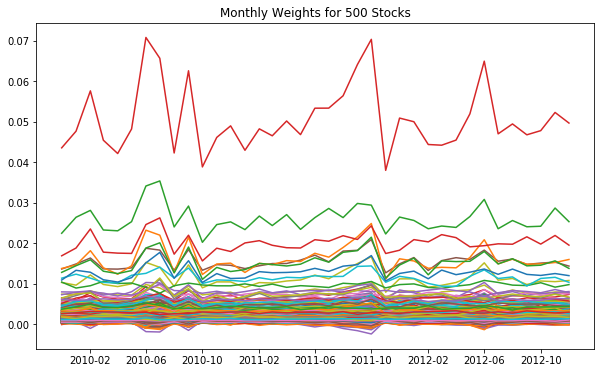

(0.006611849370249582, <Figure size 720x432 with 1 Axes>)

In [32]:
hackathon_weights(stocks,factors)